In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, StorageLevel
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, sum

In [2]:
conf = SparkConf().setMaster('local[*]').setAppName("CarsData") \
.set("spark.driver.memory", "10g") \
.set("spark.executor.memory", "12g") \
.set("spark.driver.memoryOverhead", "512m") \
.set("spark.executor.memoryOverhead", "512m")

spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc = spark.sparkContext


In [3]:
data = spark.read.options(header=True, 
                        escape='"', 
                        multiline=True,
                        ).csv('hdfs://localhost:9000/input/used_cars_data.csv')

In [9]:
row_count = data.count()
column_count = len(data.columns)

print(f"Rows: {row_count}, Columns: {column_count}")

Rows: 3000040, Columns: 66


In [4]:
data.printSchema()

root
 |-- vin: string (nullable = true)
 |-- back_legroom: string (nullable = true)
 |-- bed: string (nullable = true)
 |-- bed_height: string (nullable = true)
 |-- bed_length: string (nullable = true)
 |-- body_type: string (nullable = true)
 |-- cabin: string (nullable = true)
 |-- city: string (nullable = true)
 |-- city_fuel_economy: string (nullable = true)
 |-- combine_fuel_economy: string (nullable = true)
 |-- daysonmarket: string (nullable = true)
 |-- dealer_zip: string (nullable = true)
 |-- description: string (nullable = true)
 |-- engine_cylinders: string (nullable = true)
 |-- engine_displacement: string (nullable = true)
 |-- engine_type: string (nullable = true)
 |-- exterior_color: string (nullable = true)
 |-- fleet: string (nullable = true)
 |-- frame_damaged: string (nullable = true)
 |-- franchise_dealer: string (nullable = true)
 |-- franchise_make: string (nullable = true)
 |-- front_legroom: string (nullable = true)
 |-- fuel_tank_volume: string (nullable = tr

The dataset only contains string so it needs to be converted.

In [5]:
data.show(5)

+-----------------+------------+----+----------+----------+---------------+-----+--------+-----------------+--------------------+------------+----------+--------------------+----------------+-------------------+-----------+--------------+-----+-------------+----------------+--------------+-------------+----------------+---------+-------------+-------+--------------------+----------+--------------------+-----+------------+------+------+---------+--------+--------+-----------+-------------+----------+---------+--------------------+--------------------+----------+---------------+-------+---------------+-----------+------------------+-------+-------+--------------+-------------+------+-------------------+-----------+--------------------+------------+--------------------+------+------------+-----------------------+------------+--------------------+---------+-------+----+
|              vin|back_legroom| bed|bed_height|bed_length|      body_type|cabin|    city|city_fuel_economy|combine_fuel_

As we can see the numerical values contain a unit of measurement after the value. This can be fixed with converting all into the same measuring unit or just remove the measuring unit if all rows contain the same.

In [22]:
data.select('sp_id').distinct().count()

30655

In the automotive context, SPID stands for Service Parts Identification. It's a label or decal found in vehicles, particularly those manufactured by General Motors (GM), that lists the various options and parts installed in the vehicle at the factory. This label is crucial for service and parts personnel to identify the specific components and options of a vehicle, ensuring accurate maintenance and repairs.

In [20]:
first_row = data.select('transmission_display').first()
transmission_display_value = first_row['transmission_display']
print(transmission_display_value)

9-Speed Automatic Overdrive


In [21]:
data.select('transmission_display').distinct().count()

[Row(transmission_display='4-Speed Automatic Overdrive'),
 Row(transmission_display='5-Speed Manual Overdrive'),
 Row(transmission_display='6-Speed CVT'),
 Row(transmission_display='7-Speed Dual Clutch'),
 Row(transmission_display='7-Speed Manual'),
 Row(transmission_display='6-Speed Automatic'),
 Row(transmission_display='7-Speed CVT'),
 Row(transmission_display='8-Speed Dual Clutch'),
 Row(transmission_display='9-Speed Automatic Overdrive'),
 Row(transmission_display='Automatic'),
 Row(transmission_display='8-Speed Manual'),
 Row(transmission_display='6-Speed Automatic Overdrive'),
 Row(transmission_display='6-Speed Manual Overdrive'),
 Row(transmission_display='8-Speed Automatic Overdrive'),
 Row(transmission_display='1-Speed Automatic'),
 Row(transmission_display='1-Speed Dual Clutch'),
 Row(transmission_display='9-Speed Automatic'),
 Row(transmission_display='Continuously Variable Transmission'),
 Row(transmission_display='5-Speed Automatic'),
 Row(transmission_display='10-Speed D

IS THIS USEFUL????

In [16]:
first_row = data.select('description').first()
description_value = first_row['description']
print(description_value)

[!@@Additional Info@@!]Engine: 2.4L I4 ZERO EVAP M-AIR,Full Size Temporary Use Spare Tire,Manufacturer's Statement of Origin,Quick Order Package 2XB,Tires: 215/60R17 BSW AS Touring,Transmission: 9-Speed 948TE Automatic,Wheels: 17' x 7.0' Aluminum


Description is a combination of column values and will therefore be removed.

In [17]:
first_row = data.select('torque').first()
torque_value = first_row['torque']
print(torque_value)

200 lb-ft @ 1,750 RPM


Split the value of torque into two columns, one will be called lb-ft and the other RPM.

In [6]:
data.select('back_legroom').distinct().collect()

[Row(back_legroom='38.5 in'),
 Row(back_legroom='28 in'),
 Row(back_legroom='36.3 in'),
 Row(back_legroom='30.6 in'),
 Row(back_legroom='31.4 in'),
 Row(back_legroom='44.4 in'),
 Row(back_legroom='42.1 in'),
 Row(back_legroom='30.2 in'),
 Row(back_legroom='24.6 in'),
 Row(back_legroom='43.5 in'),
 Row(back_legroom='41.2 in'),
 Row(back_legroom='17.1 in'),
 Row(back_legroom='33.7 in'),
 Row(back_legroom='30.4 in'),
 Row(back_legroom='28.4 in'),
 Row(back_legroom='33.4 in'),
 Row(back_legroom='33.8 in'),
 Row(back_legroom='35.5 in'),
 Row(back_legroom='32.6 in'),
 Row(back_legroom='32.5 in'),
 Row(back_legroom='23.7 in'),
 Row(back_legroom='35 in'),
 Row(back_legroom='34.7 in'),
 Row(back_legroom='23.5 in'),
 Row(back_legroom='32.4 in'),
 Row(back_legroom='26 in'),
 Row(back_legroom='46.9 in'),
 Row(back_legroom='28.3 in'),
 Row(back_legroom='40.1 in'),
 Row(back_legroom='38.9 in'),
 Row(back_legroom='41.6 in'),
 Row(back_legroom='59.8 in'),
 Row(back_legroom='27.7 in'),
 Row(back_legroo

Here we can see that all rows for that column have inch therefore we can remove the 2 outmost to the right and it becomes numerical. This will be done to all columns that have the same issue.

In [12]:

import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum

def plot_null_values(df):
    """
    This function takes a PySpark DataFrame and plots the number of null values in each column.
    
    Args:
    df (pyspark.sql.DataFrame): The PySpark DataFrame to analyze.
    
    Returns:
    None: Displays a bar chart of null values per column.
    """
    
    # Step 1: Count the null values for each column
    null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
    
    # Step 2: Collect the results into a dictionary where key is the column name, and value is the null count
    null_counts_dict = null_counts.collect()[0].asDict()
    
    # Step 3: Prepare data for plotting
    columns = list(null_counts_dict.keys())
    null_values = [val / 3000040 for val in list(null_counts_dict.values())]
    
    # Step 4: Plot the data using Matplotlib
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.barh(columns, null_values, color='skyblue',height=0.6)  # Create a horizontal bar plot
    
    plt.xlabel('Number of Null Values (scaled by 1/3000040)', fontsize=12)  # X-axis label
    plt.ylabel('Columns', fontsize=12)  # Y-axis label
    plt.title('Number of Null Values Per Column', fontsize=14)  # Title of the plot
    
    # Annotate the bar plot with the null counts
    for i, val in enumerate(null_values):
        plt.text(val + 0.01, i, f'{val:.4f}', ha='left', va='center', fontsize=10)
    
    plt.tight_layout()  # Ensure the layout fits well
    plt.show()  # Display the plot



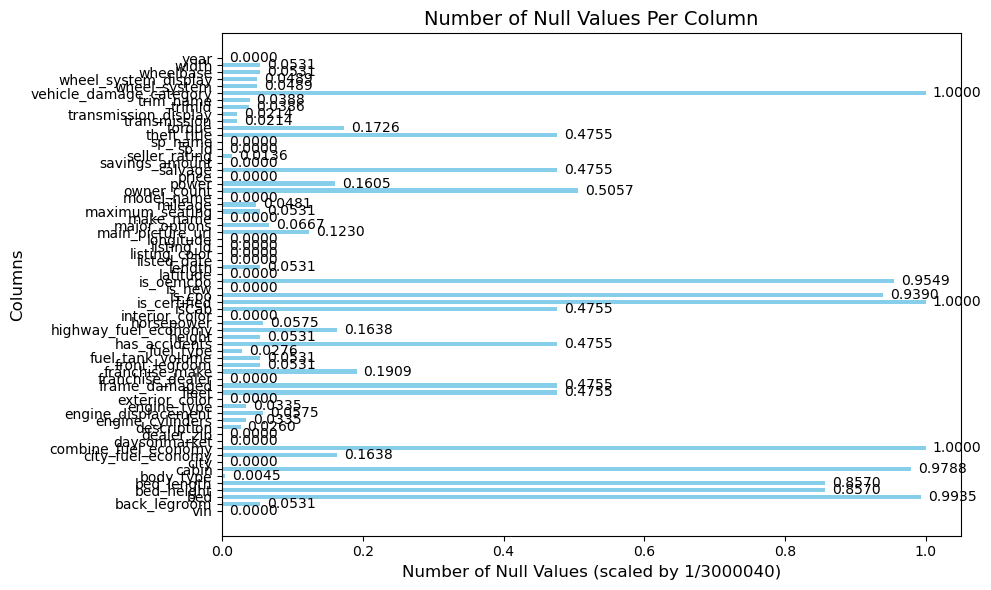

In [13]:
plot_null_values(data)

| Rows to drop | Reason |
|----|---|
| Vin | Is unique|
|Listing ID| Is unique|
|Description|Combination of column values|
|whatever|>30% missing values|
